# Bayesian data analysis - roaches cross-validation demo

Demonstration of simple misspecified model. In this case, cross-validation is useful to detect misspecification.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.3


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
roaches = pd.read_csv('roaches.csv', sep=' ')
roaches.head()

,y,roach1,treatment,senior,exposure2
0,153,3.0800,1,0,0.800000
1,127,3.3125,1,0,0.600000
2,7,0.0167,1,0,1.000000
3,7,0.0300,1,0,1.000000
4,0,0.0200,1,0,1.142857


In [3]:
scale = np.std(roaches[['roach1', 'treatment', 'senior']])

In [4]:
2.5/scale.values

array([3.32808818, 5.10970805, 5.42825964])

In [5]:
with pm.Model() as glmp:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, senior, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 587.07it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '5521' (I am process '5522')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '5521' (I am process '5523')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '5522' (I am process '5523')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubunt

In [6]:
pm.summary(trace0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,3.088956,0.020523,0.000341,3.048782,3.127582,3467.793421,1.000304
roach1,0.698237,0.008726,0.000138,0.681347,0.715676,4115.133364,0.999885
treatment,-0.516633,0.024356,0.000380,-0.561595,-0.466552,4171.769179,0.999800
senior,-0.380086,0.033195,0.000499,-0.442777,-0.312632,4074.134917,0.999826
mu,84.796495,1705.234761,34.016919,0.001056,132.552112,2492.413861,1.000349


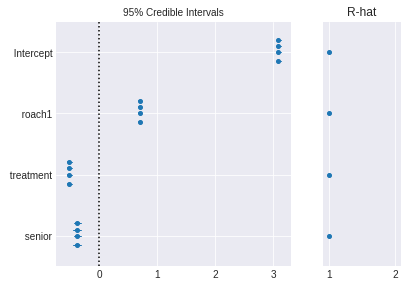

In [7]:
pm.forestplot(trace0, 
              varnames=['Intercept', 'roach1', 'treatment', 'senior']);

In [8]:
import loo
df_loo, pointwise = loo.loo(trace0, model=glmp)

Computed from 4000 by 262 log-likelihood matrix


In [9]:
df_k = loo.ks_summary(pointwise['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    238  90.839695      (good)
 (0.5, 0.7]     10   3.816794        (ok)
   (0.7, 1]      4   1.526718       (bad)
   (1, Inf)     10   3.816794  (very bad)


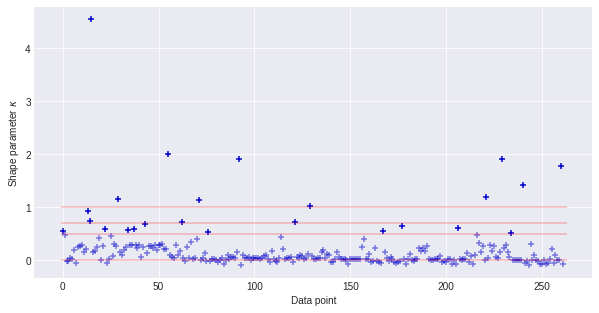

In [10]:
loo.plot_khat(pointwise['ks']);

In [11]:
with pm.Model() as glm1p:
    pm.glm.GLM.from_formula(
        'y ~ treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace1 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, senior, treatment, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 586.25it/s]


In [12]:
with pm.Model() as glm2p:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace2 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, senior, roach1, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 557.59it/s]


In [13]:
with pm.Model() as glm3p:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace3 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 633.83it/s]
The acceptance probability does not match the target. It is 0.8807137829193666, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
df_loo1, pointwise1 = loo.loo(trace1, model=glm1p)
comp1 = loo.compare([pointwise1, pointwise])
comp1.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,2229.8,614.2


In [15]:
df_loo2, pointwise2 = loo.loo(trace2, model=glm2p)
comp2 = loo.compare([pointwise2, pointwise])
comp2.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,189.3,194.2


In [16]:
df_loo3, pointwise3 = loo.loo(trace3, model=glm3p)
comp3 = loo.compare([pointwise3, pointwise])
comp3.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,35.5,108.6


Poster prediction check with statistics

100%|██████████| 500/500 [00:00<00:00, 2853.87it/s]


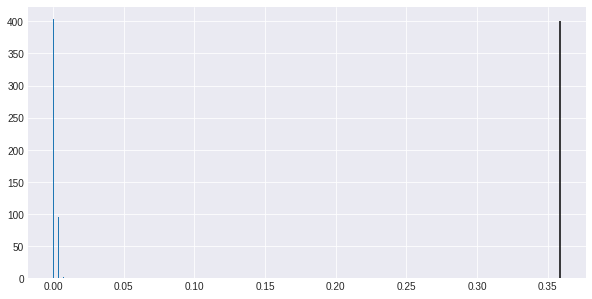

In [17]:
ppc = pm.sample_ppc(trace0, samples=500, model=glmp)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist((ppc['y']==0).mean(axis=1))
ax.vlines((roaches['y']==0).mean(), 0, 400);

In [18]:
neg_binom_fam = pm.glm.families.NegativeBinomial(
    priors = {'alpha': pm.Exponential.dist(lam=1)})
with pm.Model() as glmnb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace0nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, alpha_log__, senior, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:04<00:00, 406.62it/s]


In [19]:
pm.summary(trace0nb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.844028,0.226099,0.004183,2.412541,3.282857,2566.812435,0.999952
roach1,1.309454,0.250643,0.003888,0.820825,1.797584,3611.429778,1.000846
treatment,-0.771893,0.244417,0.004247,-1.239685,-0.292130,3384.117438,0.999785
senior,-0.323160,0.267323,0.004224,-0.822077,0.206919,4146.513160,0.999690
alpha,0.271251,0.025824,0.000363,0.224429,0.325095,5444.907219,0.999802
mu,78.906376,1770.628776,28.576672,0.003017,138.743470,3755.187077,0.999950


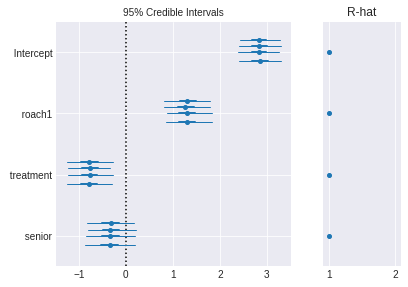

In [20]:
pm.forestplot(trace0nb, 
              varnames=['Intercept', 'roach1', 'treatment', 'senior']);

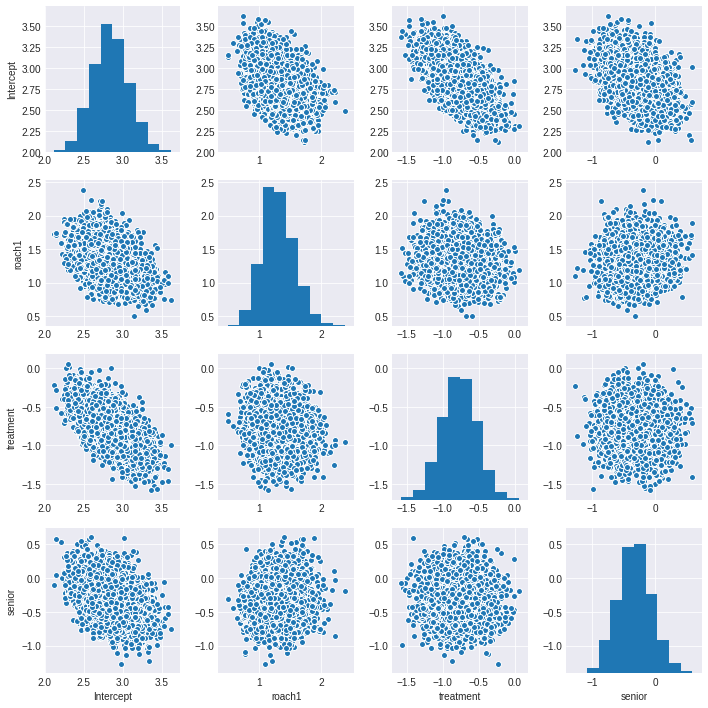

In [21]:
import seaborn as sns
tracedf0 = pm.trace_to_dataframe(trace0nb,
                                 varnames=['Intercept', 'roach1', 'treatment', 'senior'])
sns.pairplot(tracedf0);

In [22]:
loo_nb, pw_nb = loo.loo(trace0nb, model=glmnb)
loo_nb

Computed from 4000 by 262 log-likelihood matrix


,Estimate,SE
elpd_loo,-895.602191,37.667370
p_loo,6.608147,2.615292
looic,1791.204382,75.334741


In [23]:
df_nb = loo.ks_summary(pw_nb['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    261  99.618321      (good)
 (0.5, 0.7]      0   0.000000        (ok)
   (0.7, 1]      0   0.000000       (bad)
   (1, Inf)      1   0.381679  (very bad)


In [24]:
compnew = loo.compare([pw_nb, pointwise])
compnew.round(1)

,elpd_diff,se
m1-m0,-5346.5,706.2


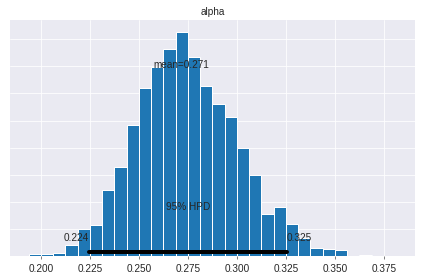

In [25]:
pm.plot_posterior(trace0nb, varnames=['alpha']);

100%|██████████| 500/500 [00:00<00:00, 1749.51it/s]


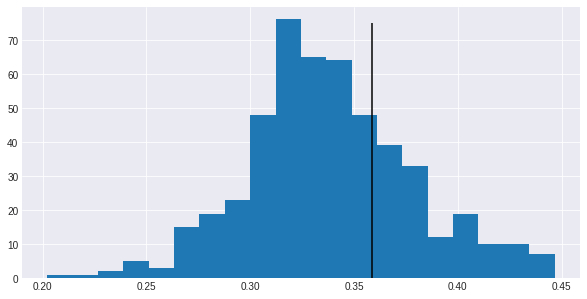

In [26]:
ppc = pm.sample_ppc(trace0nb, samples=500, model=glmnb)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist((ppc['y']==0).mean(axis=1), 20)
ax.vlines((roaches['y']==0).mean(), 0, 75);

In [27]:
with pm.Model() as glm1nb:
    pm.glm.GLM.from_formula(
        'y ~ treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace1nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, alpha_log__, senior, treatment, Intercept]
100%|██████████| 2000/2000 [00:04<00:00, 457.81it/s]


In [28]:
with pm.Model() as glm2nb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace2nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, alpha_log__, senior, roach1, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 506.69it/s]


In [29]:
with pm.Model() as glm3nb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace3nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, alpha_log__, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 516.81it/s]


In [30]:
loo_nb1, pw_nb1 = loo.loo(trace1nb, model=glm1nb)
comp1_ = loo.compare([pw_nb1, pw_nb])
comp1_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,21.6,6.0


In [31]:
loo_nb2, pw_nb2 = loo.loo(trace2nb, model=glm2nb)
comp2_ = loo.compare([pw_nb2, pw_nb])
comp2_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,3.3,4.4


In [32]:
loo_nb3, pw_nb3 = loo.loo(trace3nb, model=glm3nb)
comp3_ = loo.compare([pw_nb3, pw_nb])
comp3_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,-1.5,2.9
